In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import time
import winsound
import copy
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [36]:

path = "C:/Users/Sebastian/Documents/Data Analytics Master/Semester4-Thesis/Datasets/FiveCitiePMData/"
files = os.listdir(path)
print(files)

['.ipynb_checkpoints', '2016JD024877.pdf', 'BeijingPM20100101_20151231.csv', 'ChengduPM20100101_20151231.csv', 'Data-exploration-five-cities.ipynb', 'GuangzhouPM20100101_20151231.csv', 'ShanghaiPM20100101_20151231.csv', 'ShenyangPM20100101_20151231.csv']


In [37]:
files = [file for file in filter(lambda x: x[-4:] ==".csv", files)]
print(files)

['BeijingPM20100101_20151231.csv', 'ChengduPM20100101_20151231.csv', 'GuangzhouPM20100101_20151231.csv', 'ShanghaiPM20100101_20151231.csv', 'ShenyangPM20100101_20151231.csv']


In [38]:
city1 = 'BeijingPM20100101_20151231.csv'
city2 = 'ChengduPM20100101_20151231.csv'
city3 = 'GuangzhouPM20100101_20151231.csv'
city4 = 'ShanghaiPM20100101_20151231.csv'
city5 = 'ShenyangPM20100101_20151231.csv'

In [118]:


def windows (data, window_size, stride):
    
    x = np.array(data)
    length = data.shape[0]
    windows_list = []
    
    for i in range(0, length-window_size, stride):
        windows_list.append(x[i:i+window_size][np.newaxis,:])
        
    return tuple(windows_list)


class TSDataset(object):
    """An abstract class representing a Dataset.
    All other datasets should subclass it. All subclasses should override
    ``__len__``, that provides the size of the dataset, and ``__getitem__``,
    supporting integer indexing in range from 0 to len(self) exclusive.
    """
    
    def __init__(self, data, window_size, stride, scale = 0, max_list=[], min_list = []):
        
        x_list = []
        y_list = []
        
        for i in range(0, len(data)-window_size, stride):             
            x_list.append(data[i:i+window_size, :-1][np.newaxis,:])
            y_list.append(data[i+window_size,-1])
        
        self.x = np.vstack(x_list)
        self.y = np.vstack(y_list)
        
        if scale:         
            self.max_list = max_list
            self.min_list = min_list
            
        else:
            self.max_y = np.max(self.y)
            self.max_list = [np.max(np.max(self.x, axis=1), axis=0), self.max_y]
            #self.max_list[0] = [i if i!=0 else 0.00001 for i in self.max_list[0]  ]
            
            self.min_y = np.min(self.y)
            self.min_list = [np.min(np.min(self.x, axis=1), axis=0), self.min_y]
            #self.min_list[0] = [i if i!=0 else 0.00001 for i in self.min_list[0]  ]
            
        
        
        #self.x = np.divide(self.x, self.max_list[0])
        #self.y = self.y/self.max_list[-1]
        #self.y = (self.y-np.mean(self.y))/np.std(self.y)
        
        print("x shape:", self.x.shape)
        print("y shape:", self.y.shape)
 

    def __getitem__(self, index):
        return self.x[index], self.y[index]

    def __len__(self):
        return self.y.shape[0]

    def __add__(self, other):
        object_copy = copy.deepcopy(self)
        object_copy.x = np.concatenate([object_copy.x, other.x], axis=0)
        object_copy.y = np.concatenate([object_copy.y, other.y], axis=0)
        
        object_copy.max_list[0] = np.max((object_copy.max_list[0], other.max_list[0]), axis=0)
        object_copy.max_list[1] = np.max((object_copy.max_list[1], other.max_list[1]), axis=0)
        object_copy.min_list[0] = np.min((object_copy.min_list[0], other.min_list[0]), axis=0)
        object_copy.min_list[1] = np.min((object_copy.min_list[1], other.min_list[1]), axis=0)
          
        
        return object_copy
    
    def normalize(self):
        
        self.x = np.divide(self.x - self.min_list[0], np.array(self.max_list[0])-np.array(self.min_list[0])+0.00001)
        self.y = (self.y - self.min_list[-1])/(self.max_list[-1] - self.min_list[-1]+0.00001)        
        


def mae(y_pred, y_true):
    loss = (torch.abs(y_pred - y_true)).mean()
    return loss    

class LSTMModel(nn.Module):
    
    def __init__(self, batch_size, seq_len, input_dim, n_layers, hidden_dim, output_dim, lin_hidden_dim = 100):
        super(LSTMModel, self).__init__()

        self.lstm = nn.LSTM(input_dim, hidden_dim, n_layers, batch_first=True)
        self.linear = nn.Linear(hidden_dim, output_dim)#
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.n_layers = n_layers
        self.hidden = self.init_hidden()
        self.input_dim = input_dim
        
    def init_hidden(self):
        # This is what we'll initialise our hidden state as
        return (torch.zeros(self.n_layers, self.batch_size, self.hidden_dim),
                torch.zeros(self.n_layers, self.batch_size, self.hidden_dim))
        
    def forward(self, x):
        
        #self.batch_size = len(x)
        self.batch_size = len(x)
        hidden = self.init_hidden()
        output, (hn, cn) = self.lstm(x)
        #out1 = self.linear(output
        out1 = self.linear(hn[-1].view(len(x),-1))
        #out2 = self.linear2(F.relu(out1))
        
        #print(output.shape)
        #out = self.linear(output.view(len(x),-1))
        return out1
    
class LinearModel(nn.Module):
    
    def __init__(self, input_dim, output_dim, seq_len):
        
        super(LinearModel, self).__init__()
        self.n_features = input_dim*seq_len
        self.linear = nn.Linear(self.n_features, output_dim)
        
    def forward(self, x):
        
        out = self.linear(x.view(-1,self.n_features))
        return out
       
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def count_na(x):
    
    return np.sum(np.isnan(x))

In [119]:
stride = 2
window_size = 24
backcast = window_size
forecast = 1

batch_size = 1024
seq_len = backcast
output_dim = forecast
input_dim = 16
n_layers = 2
hidden_dim = 30

var = ['month', 'day', 'hour', 'season', 'DEWP', 'HUMI',
       'PRES', 'TEMP', 'cbwd', 'Iws', 'precipitation', 'Iprec', 'PM_US Post'] #PM_US Post is the targe

cbwd_dict = {"NE":1, "SE":2, "SW":3, "NW":4, "cv":0}


In [120]:
data = pd.read_csv(path+files[0])


def pre_process(data, var):

    #imputing target
    data[("PM_US Post")].loc[np.isnan(data["PM_US Post"])] = 0

    #imputing numerical vars
    for i, v in enumerate(var):    
        try:
            data[v] = data[v].interpolate()
        except:
            pass

    #new varibale for calm and variable wind
    data["cv_wd"] = (data["cbwd"]=="cv").astype(int)

    #inputting wind directioin
    data["cbwd"] = data["cbwd"].replace(cbwd_dict)
    
    data["na_cbwd"] = np.isnan(data["cbwd"]).astype(int)
    data[("cbwd")].loc[np.isnan(data["cbwd"])] = -1
    
    data["na_precipitation"] = np.isnan(data["precipitation"]).astype(int)
    data[("precipitation")].loc[np.isnan(data["precipitation"])] = -1
    
    data["na_Iprec"] = np.isnan(data["Iprec"]).astype(int)
    data[("Iprec")].loc[np.isnan(data["Iprec"])] = -1
   
    var = var[:-1] + ["na_cbwd", "na_precipitation", "na_Iprec", "cv_wd"] +[var[-1]]
    #padding wind direction column
    #print("NAs before padding:", data.cbwd.isna().sum())
    #data["cbwd"] = data["cbwd"].fillna(method="pad", limit=100)
    #print("NAs after padding:", data.cbwd.isna().sum())

    return data[var]

In [121]:

data = pd.read_csv(path+files[0])
data = np.array(pre_process(data, var))
idx = np.arange(len(data))
train_split = int(len(data)*0.6)
val_split = int(len(data)*0.8)

train_idx = idx[:train_split]
val_idx = idx[train_split:val_split]
test_idx = idx[val_split:]

train_dataset = TSDataset(data[train_idx], window_size, stride)
test_dataset = TSDataset(data[test_idx], window_size, stride, scale = 1, max_list = train_dataset.max_list, min_list = train_dataset.min_list)
val_dataset = TSDataset(data[val_idx], window_size, stride, scale = 1, max_list = train_dataset.max_list, min_list = train_dataset.min_list)

#test_dataset = TSDataset(data[test_idx], window_size, stride, standarize = 1, mean_list = train_dataset.mean_list, std_list = train_dataset.std_list)
#val_dataset = TSDataset(data[val_idx], window_size, stride, standarize = 1, mean_list = train_dataset.mean_list, std_list = train_dataset.std_list)



for file in files[1:1]:
    data = pd.read_csv(path+file)
    data = np.array(pre_process(data, var))
    idx = np.arange(len(data))
    train_split = int(len(data)*0.6)
    val_split = int(len(data)*0.8)
    #dont apply it for time series
    #np.random.shuffle(idx)

    train_idx = idx[:train_split]
    val_idx = idx[train_split:val_split]
    test_idx = idx[val_split:]

    train_dataset = TSDataset(data[train_idx], window_size, stride) + train_dataset
    test_dataset = TSDataset(data[test_idx], window_size, stride, scale = 1, max_list = train_dataset.max_list, min_list = train_dataset.min_list) + test_dataset
    val_dataset = TSDataset(data[val_idx], window_size, stride, scale = 1, max_list = train_dataset.max_list, min_list = train_dataset.min_list) + test_dataset
    #test_dataset = TSDataset(data[test_idx], window_size, stride, standarize = 1, mean_list = train_dataset.mean_list, std_list = train_dataset.std_list)
    #val_dataset = TSDataset(data[val_idx], window_size, stride, standarize = 1, mean_list = train_dataset.mean_list, std_list = train_dataset.std_list)

    
#train_dataset.normalize()
#test_dataset.normalize()
#val_dataset.normalize()

train_dataset.normalize()
test_dataset.normalize()
val_dataset.normalize()


print("Training size:", train_dataset.x.shape)

x shape: (15763, 24, 16)
y shape: (15763, 1)
x shape: (5247, 24, 16)
y shape: (5247, 1)
x shape: (5247, 24, 16)
y shape: (5247, 1)
Training size: (15763, 24, 16)


In [128]:
params = {'batch_size': batch_size,
          'shuffle': True,
          'num_workers': 0}



train_loader = DataLoader(train_dataset, **params)
train_iter = iter(train_loader)

test_loader = DataLoader(test_dataset, **params)
test_iter = iter(test_loader)

val_loader = DataLoader(val_dataset, **params)
val_iter = iter(val_loader)


In [129]:
model = LSTMModel (batch_size, seq_len, input_dim, n_layers, hidden_dim, output_dim)

print("Model size:", count_parameters(model))

optimizer = optim.Adam(model.parameters(), lr=0.0001)
max_epochs = 100
val_loss_list = []
prev_loss = np.inf

Model size: 13231


In [137]:
#optimizer = optim.Adam(model.parameters(), lr=0.00001)

scheduler = ReduceLROnPlateau(optimizer, 'min')

start = time.time()


for i in range(max_epochs):
    
    train_iter = iter(train_loader)
    train_loss = 0.0
    for x_train, y_train in train_iter:
    
        model.zero_grad()
        x_train, y_train = torch.tensor(x_train).float(), torch.tensor(y_train).float()

        #model.batch_size = x_train.shape[0]
        #hidden_init = model.init_hidden()
        y_pred = model(x_train)
        loss = mae(y_pred, y_train)
        loss.backward()
        optimizer.step()
        train_loss += loss.data.numpy()*x_train.shape[0]
    print("Train loss:", train_loss/len(train_dataset))
        
        
    val_loss = 0.0
    for x_val, y_val in val_loader:
        x_val, y_val = torch.tensor(x_val).float(), torch.tensor(y_val).float()
        #if(x_val.shape[0]==batch_size):
        model.batch_size = x_val.shape[0]
        hidden_init = model.init_hidden()
        y_pred = model(x_val)
        val_loss += mae(y_pred, y_val).data.numpy()*x_val.shape[0]
    val_loss /= (len(val_dataset)*forecast)
    
    #if(val_loss>prev_loss):
    #    break
        
    prev_loss = val_loss
    val_loss_list.append(val_loss)
    print(val_loss)
    
    scheduler.step(val_loss)
    
end = time.time()
print(end - start)

frequency = 2500  # Set Frequency To 2500 Hertz
duration = 100  # Set Duration To 1000 ms == 1 second
winsound.Beep(frequency, duration)

C:\Users\Sebastian\Anaconda3\envs\pytorch12\lib\site-packages\ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app


Train loss: 0.04652414912637861


C:\Users\Sebastian\Anaconda3\envs\pytorch12\lib\site-packages\ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


0.04457782396213518
Train loss: 0.046453610178874186
0.044818696683251065
Train loss: 0.04637803774924249
0.0453131398445587
Train loss: 0.04628751874357615
0.04450951292131068
Train loss: 0.04624058955182946
0.04507569024704605
Train loss: 0.04620456205381889
0.04477709755500271
Train loss: 0.04617111827304451
0.04446451058595299
Train loss: 0.04619247773272854
0.044824556464072705
Train loss: 0.04613777161214563
0.04466528036602002
Train loss: 0.046082202630148374
0.04516109799828124
Train loss: 0.04605150750411583
0.04455086884923224
Train loss: 0.04599626000996835
0.044286935448743105
Train loss: 0.046031854005473404
0.044634584294163844
Train loss: 0.04589515573147256
0.04474935261310794
Train loss: 0.045930838620869524
0.0448558685279799
Train loss: 0.0458624979427572
0.04445792984040619
Train loss: 0.04579093757302395
0.04471784888170141
Train loss: 0.04580024810199363
0.04433180834677007
Train loss: 0.045726292553046236
0.04483365004536809
Train loss: 0.04574487867412936
0.0442

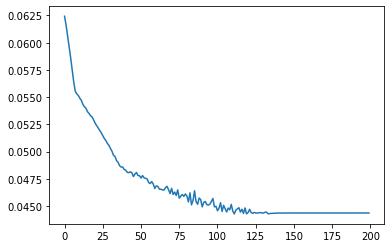

In [138]:
plt.plot(val_loss_list)

In [139]:
samples = 400
model.batch_size = samples
y_pred = model(torch.tensor(test_dataset.x[samples:samples+samples]).float())

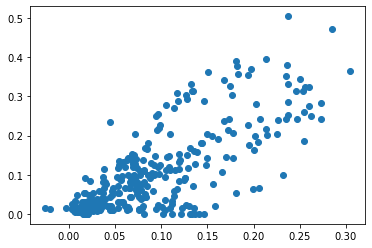

In [140]:
plt.scatter(y_pred.detach().numpy(), test_dataset.y[samples:(2*samples)])

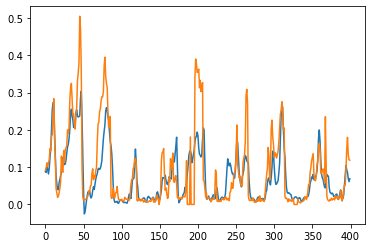

In [141]:
plt.plot(y_pred.detach().numpy())
plt.plot( test_dataset.y[samples:(2*samples)])

In [135]:
np.mean(train_dataset.x, axis=0).shape

(24, 16)